In [ ]:
!pip install pandas
!pip install numpy
!pip install category_encoders
!pip install contractions
!pip install wordcloud
!pip install nltk
!pip install gensim
!pip install xgboost
!pip install matplotlib

In [2]:
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import category_encoders as ce
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### PYTHON VERSION USED 3.8.13
### note that a different version used may result in slightly erroneous lines due to depreciation of certain functions

# Preparing Datasets

In [3]:
df = pd.read_csv('fake_job_postings.csv')
df.shape
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## Cleaning Data 

In [4]:
df.drop_duplicates(subset=['title', 'company_profile', 'description', 'requirements', 'benefits', 'location', 'department', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent'], keep='first', inplace=True)
df.shape

(17599, 18)

## EDA 

In [5]:
#Finding number of NA values
df.isna().sum()

job_id                     0
title                      0
location                 341
department             11328
salary_range           14772
company_profile         3282
description                1
requirements            2648
benefits                7106
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3428
required_experience     6962
required_education      8009
industry                4837
function                6363
fraudulent                 0
dtype: int64

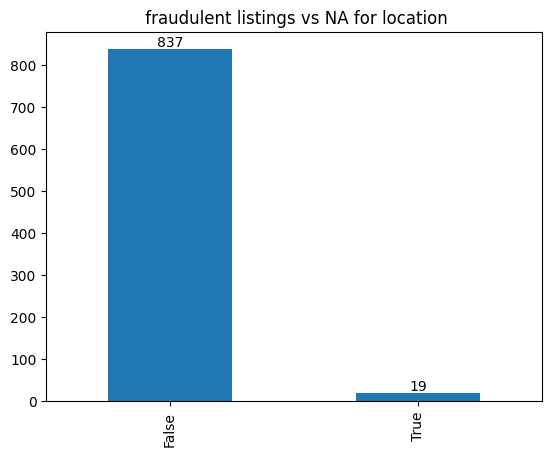

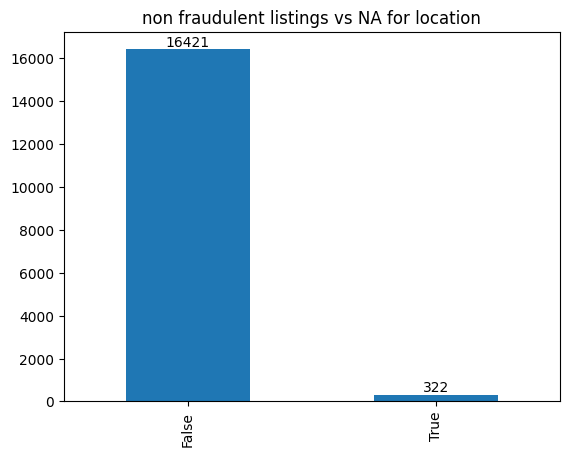

In [6]:
#General EDA questions
#are fraudulent listings more likely to have na for location?
location_na_fraud = (df[df['fraudulent'] == 1]['location'].isna()).value_counts().plot(kind="bar")
location_na_fraud.bar_label(location_na_fraud.containers[0])
plt.title(" fraudulent listings vs NA for location")
plt.show()

location_na_nofraud = (df[df['fraudulent'] == 0]['location'].isna()).value_counts().plot(kind="bar")
location_na_nofraud.bar_label(location_na_nofraud.containers[0])
plt.title("non fraudulent listings vs NA for location")
plt.show()

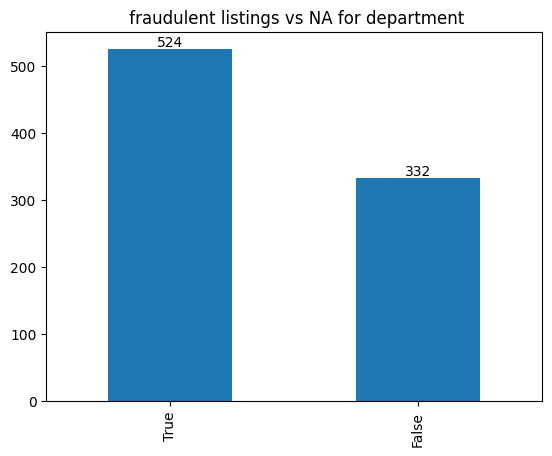

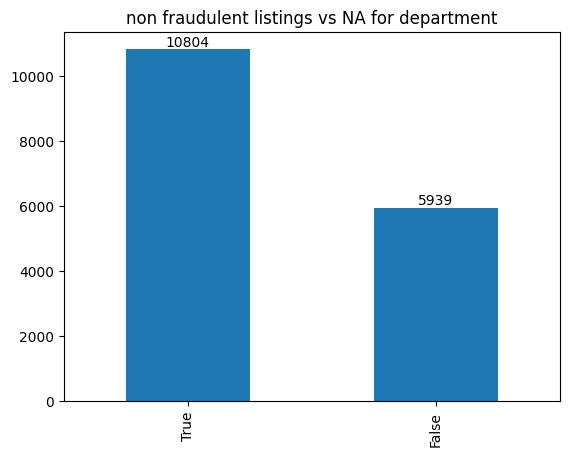

In [7]:
#are fraudulent listings more likely to have na for department?
department_na_fraud = (df[df['fraudulent'] == 1]['department'].isna()).value_counts().plot(kind="bar")
department_na_fraud.bar_label(department_na_fraud.containers[0])
plt.title(" fraudulent listings vs NA for department")
plt.show()

department_na_nofraud = (df[df['fraudulent'] == 0]['department'].isna()).value_counts().plot(kind="bar")
department_na_nofraud.bar_label(department_na_nofraud.containers[0])
plt.title("non fraudulent listings vs NA for department")
plt.show()

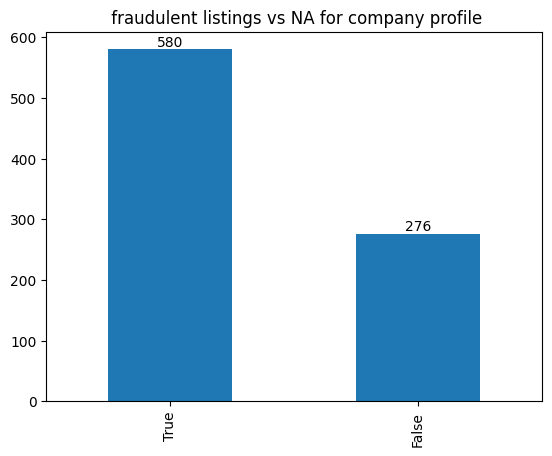

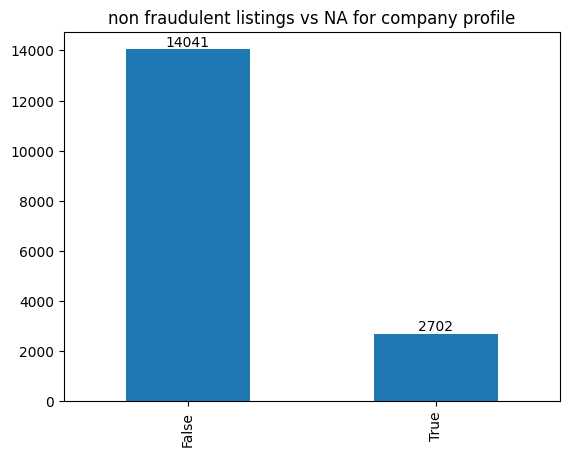

In [8]:
#are fraudulent listings more likely to have na for company_profile?
company_na_fraud = (df[df['fraudulent'] == 1]['company_profile'].isna()).value_counts().plot(kind="bar")
company_na_fraud.bar_label(company_na_fraud.containers[0])
plt.title(" fraudulent listings vs NA for company profile")
plt.show()

company_na_nofraud = (df[df['fraudulent'] == 0]['company_profile'].isna()).value_counts().plot(kind="bar")
company_na_nofraud.bar_label(company_na_nofraud.containers[0])
plt.title("non fraudulent listings vs NA for company profile")
plt.show()

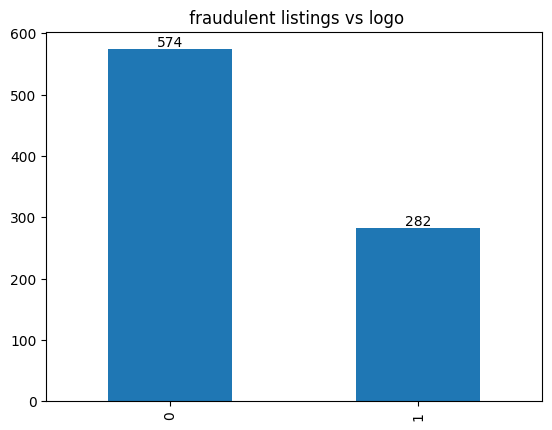

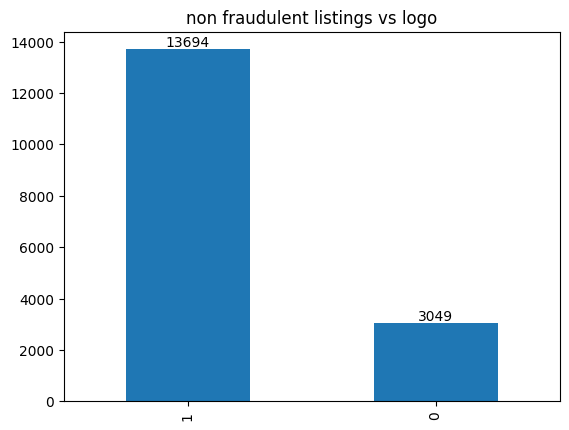

In [9]:
#are fraudulent listings more likely to have F for company logo?
logo_na_fraud = df[df['fraudulent'] == 1]['has_company_logo'].value_counts().plot(kind="bar")
logo_na_fraud.bar_label(logo_na_fraud.containers[0])
plt.title(" fraudulent listings vs logo")
plt.show()

logo_na_nofraud = (df[df['fraudulent'] == 0]['has_company_logo']).value_counts().plot(kind="bar")
logo_na_nofraud.bar_label(logo_na_nofraud.containers[0])
plt.title("non fraudulent listings vs logo")
plt.show()

#we find logo to be a potential factor in fraud listings

In [10]:
# EDA for feature engineering in textual data
def containsDollar(x):
    if '$' in x:
        return True
    return False

def containsEmail(x):
    if 'EMAIL' in x:
        return True
    return False

def containsPhone(x):
    if 'PHONE' in x:
        return True
    return False

new_df=df.copy(deep=True)

# 1) Find Titles with $ Sign
new_df['Title_Contain_$'] = df['title'].apply(containsDollar)

# 3) Description which contains emaillink
new_df['containEmailLink'] = df['description'].str.contains("#EMAIL")

# 4) description contains phonelink
new_df['containPhoneLink'] = df['description'].str.contains("#PHONE")

<AxesSubplot:xlabel='Title_Contain_$', ylabel='proportion of fraud'>

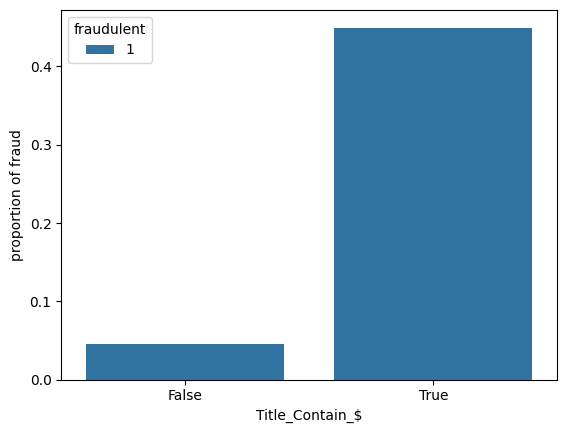

In [11]:
title_contains_dollar = new_df.groupby(['Title_Contain_$'])['fraudulent'].value_counts(normalize=True).reset_index(name = 'proportion of fraud')

title_contains_dollar_ = title_contains_dollar.loc[title_contains_dollar['fraudulent'] == 1]

sns.barplot(x = 'Title_Contain_$', y = 'proportion of fraud', hue = 'fraudulent', data = title_contains_dollar_)

<AxesSubplot:xlabel='containEmailLink', ylabel='proportion of fraud'>

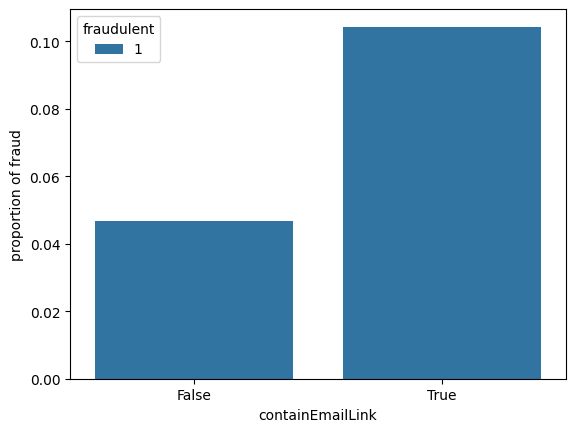

In [12]:
desc_contains_email = new_df.groupby(['containEmailLink'])['fraudulent'].value_counts(normalize=True).reset_index(name = 'proportion of fraud')

desc_contains_email_ = desc_contains_email.loc[desc_contains_email['fraudulent'] == 1]

sns.barplot(x = 'containEmailLink', y = 'proportion of fraud', hue = 'fraudulent', data = desc_contains_email_)

<AxesSubplot:xlabel='containPhoneLink', ylabel='proportion of fraud'>

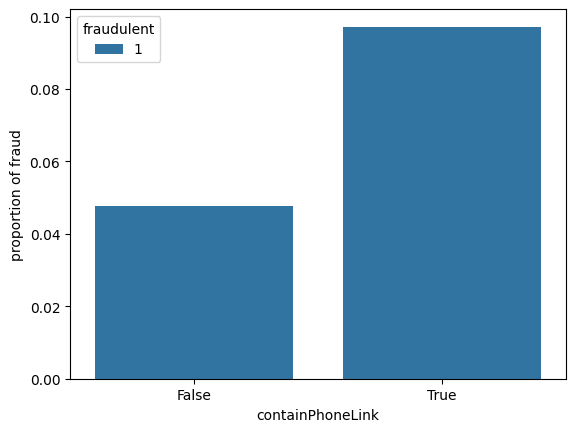

In [13]:
desc_contains_phone = new_df.groupby(['containPhoneLink'])['fraudulent'].value_counts(normalize=True).reset_index(name = 'proportion of fraud')

desc_contains_phone_ = desc_contains_phone.loc[desc_contains_phone['fraudulent'] == 1]

sns.barplot(x = 'containPhoneLink', y = 'proportion of fraud', hue = 'fraudulent', data = desc_contains_phone_)

Due to the difference in percentages of the following variables in fraud and non fraud listing, we will be considering the above 3 factors of title contains $, contain email link and contain phone link in our feature engineering

## Feature Engineering

In [ ]:
#Code Cleaning for Textual features 
import unicodedata
from wordcloud import WordCloud
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords
import contractions
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords as nltk_stopwords

def basic_clean(string):
    string = re.sub(r'<[^>]+>', '', string)
    
    string = contractions.fix(string)

    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')

    string = re.sub(r'#\S+#', '', string)

    string = re.sub(r'(http|https|www)\S+', '', string)

    string = re.sub(r'\S+@\S+', '', string)

    string = re.sub(r'[^a-zA-Z\s]', '', string)

    string = re.sub(r'\s+', ' ', string).strip()

    string = re.sub(r'\b[a-zA-Z]\b', '', string)

    return string

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    return string


def removestopwords(string, extra_words=[], exclude_words=[]):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    string = string.lower()
    all_stopwords = set(word.lower() for word in STOPWORDS).union(set(word.lower() for word in nltk_stopwords.words('english'))).union(set(extra_words)).difference(set(exclude_words))
    
    # Tokenize the string, lowercase all tokens, remove stopwords, and join the remaining tokens
    tokens = string.split()
    tokens = [word for word in tokens if word.lower() not in all_stopwords]
    string = ' '.join(tokens)

    return string

def clean_column(column):
    '''
    This function applies cleaning steps to a DataFrame column containing text.
    '''
    cleaned_texts = []
    for entry in column:
        if isinstance(entry, str):  # Check if it's a string
            cleaned_entry = removestopwords(lemmatize(basic_clean(tokenize(entry))))
            cleaned_texts.append(cleaned_entry)
        else:
            cleaned_texts.append('')  # If not a string, replace with an empty string
    return cleaned_texts


df.fillna(' ', inplace=True)
df['combined_text'] = df['title']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']
# Define the batch size
batch_size = 50

# Iterate through the data in batches
for i in range(0, len(df), batch_size):
    batch = df['combined_text'].iloc[i:i+batch_size]
    cleaned_batch = clean_column(batch)
    df['combined_text'].iloc[i:i+batch_size] = cleaned_batch

In [15]:
# 1) Find Titles with $ Sign 
containstitle = []
for idx, i in enumerate(df['title']):
    if "$" in i:
        containstitle.append(idx)
df['Title_Contain_$'] = False
df['Title_Contain_$'].loc[df.index.isin(containstitle).copy()] = True


# 2) Find Length of Text
df['description'] = df['description'].fillna("")
df['company_profile'] = df['company_profile'].fillna("")
df['requirements'] = df['requirements'].fillna("")
df['benefits'] = df['benefits'].fillna("")

#df['description'][df['description'].isna()] = "" #change all na values to empty strings
df['LengthofText'] = df['title'].apply(lambda x: len(x)) + df['description'].apply(lambda x: len(x))+ df['requirements'].apply(lambda x: len(x))+ df['benefits'].apply(lambda x: len(x)) + df['company_profile'].apply(lambda x: len(x))

# 3) Description which contains emaillink
df['containEmailLink'] = df['description'].str.contains("#EMAIL")

# 4) description contains phonelink
df['containPhoneLink'] = df['description'].str.contains("#PHONE")

# 5) Feature Engineering with relation to nontext, #Target encoding as too many locations and we only using countries
#df['location'][df['location'].isna()] = ",,"
df['location'] = df['location'].fillna(",,")

df['country']=df['location'].apply(lambda x: x.split(",")[0])

# 6) contains salary range
df['containsSalaryRange'] = ~df['salary_range'].isna()

# 7) contains department
df['containsDepartment'] = ~df['department'].isna()

# TrainTestSplit

In [16]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=0)

print(train_dataset.shape)
print(test_dataset.shape)

(14079, 26)
(3520, 26)


# Encoding

In [17]:
#Target Encoder for Country 
from sklearn.preprocessing import OneHotEncoder

encoder=ce.TargetEncoder(cols='country')
train_dataset['country_fraud'] = encoder.fit_transform(train_dataset['country'], train_dataset['fraudulent'])
test_dataset['country_fraud'] = encoder.transform(test_dataset['country'], test_dataset['fraudulent'])


# Impute categorical features with mode values
cols_to_impute = ['required_education', 'required_experience', 'function', 'industry', 'employment_type']
train_dataset[cols_to_impute]=train_dataset[cols_to_impute].fillna('Missing')
test_dataset[cols_to_impute]=test_dataset[cols_to_impute].fillna('Missing')
print(train_dataset.shape)

# encode categorical variables
columns_for_ohe = ['employment_type', 'required_education', 'required_experience', 'industry', 'function']
ohe = OneHotEncoder(handle_unknown='ignore')
ohe_train = pd.DataFrame(ohe.fit_transform(train_dataset[columns_for_ohe]).toarray())
ohe_train.columns = ohe.get_feature_names_out()
ohe_test = pd.DataFrame(ohe.transform(test_dataset[columns_for_ohe]).toarray())
ohe_test.columns = ohe.get_feature_names_out()

print(ohe_train.shape)
print(ohe_test.shape)


(14079, 27)
(14079, 197)
(3520, 197)


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

#Concatenate the two dataframes
encoded = [ohe_train.reset_index(drop=True), train_dataset.reset_index(drop=True)]
train_dataset_enc = pd.concat(encoded, axis = 1)
encoded = [ohe_test.reset_index(drop=True), test_dataset.reset_index(drop=True)]
test_dataset_enc = pd.concat(encoded, axis = 1)

#Scale Length of Text
cols_to_scale = ['LengthofText']
scaler = StandardScaler()
train_dataset_enc[cols_to_scale] = scaler.fit_transform(train_dataset_enc[cols_to_scale]) # .values.reshape(-1, 1)
test_dataset_enc[cols_to_scale] = scaler.transform(test_dataset_enc[cols_to_scale])

tfidf_vect = TfidfVectorizer()
tfidf_vect.fit_transform(train_dataset_enc['combined_text'])


# drop all unused columns
# include all columns to be dropped here
to_drop = ['job_id', 'salary_range', 'department', 'location', 'country', 'title','company_profile','description','requirements','benefits',] + columns_for_ohe
train_dataset_enc.drop(columns = to_drop, inplace=True)
test_dataset_enc.drop(columns = to_drop, inplace=True)
print(to_drop)

target_col = ['fraudulent']
X_train = train_dataset_enc.drop(target_col, axis=1)
y_train = train_dataset_enc[target_col].copy()
X_test  = test_dataset_enc.drop(target_col, axis=1)
y_test  = test_dataset_enc[target_col].copy()

['job_id', 'salary_range', 'department', 'location', 'country', 'title', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_education', 'required_experience', 'industry', 'function']


# Model 

In [207]:
#FOR NON TEXT CODE TO WORK
X_train_nonText = X_train.drop(['combined_text'], axis = 1)
X_test_nonText = X_test.drop(['combined_text'], axis = 1)

X_train_Text = X_train['combined_text']
X_test_Text = X_test['combined_text']

print(X_train_Text.shape)
print(X_train_nonText.shape)

(14079,)
(14079, 207)


## Using only Non-Text variables

In [208]:
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
ModelValuesNonText = {}
def fit_ml_algo_class(algo, X_train, X_test, Y_train, Y_test, name):
    start_time = time.time()
    print(f"Model used {name}")
    print("Performing Cross Validation:")
    

    scores_count_vectors = cross_val_score(algo, X_train, Y_train, cv=5, scoring='accuracy')
    print(f"Cross-validated Accuracy for model: {scores_count_vectors.mean()}\n")

    algo.fit(X_train, Y_train)
    Y_pred = algo.predict(X_test)

    classreport = classification_report(Y_test, Y_pred, output_dict = True)
    print(classreport)

    modeltype = name + " NON - TEXT "
    ModelValuesNonText[modeltype] = [algo, 
                        classreport['accuracy'], 
                        classreport['macro avg']['precision'], 
                        classreport['macro avg']['recall'], 
                        classreport['macro avg']['f1-score'], 
                        scores_count_vectors.mean(),
                        (time.time() - start_time)]
    print("\n\n")
    return model

# XGBoost
params = {'subsample': 1.0, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.01, 'colsample_bytree': 1.0}
fit_ml_algo_class(XGBClassifier(), 
X_train_nonText, X_test_nonText, y_train,y_test, "XGBoost")

# SVM
fit_ml_algo_class(svm.SVC(random_state=0, C = 1, gamma = 0.1, kernel= 'rbf', probability=True), 
 X_train_nonText, X_test_nonText, y_train,y_test, "SVM")

# Logistic Regression
fit_ml_algo_class(LogisticRegression(penalty='l1', solver='liblinear'), 
X_train_nonText, X_test_nonText, y_train,  y_test, "Logistic Regression")

# Random Forest
fit_ml_algo_class(RandomForestClassifier(max_features = 6, n_estimators = 30),
 X_train_nonText,  X_test_nonText, y_train, y_test,"Random Forest")


Model used XGBoost
Performing Cross Validation:
Cross-validated Accuracy for model: 0.9762056202567415

{'0': {'precision': 0.9802767147483074, 'recall': 0.9955156950672646, 'f1-score': 0.9878374369623257, 'support': 3345.0}, '1': {'precision': 0.8780487804878049, 'recall': 0.6171428571428571, 'f1-score': 0.7248322147651006, 'support': 175.0}, 'accuracy': 0.9767045454545454, 'macro avg': {'precision': 0.9291627476180562, 'recall': 0.8063292761050609, 'f1-score': 0.8563348258637131, 'support': 3520.0}, 'weighted avg': {'precision': 0.9751943600620607, 'recall': 0.9767045454545454, 'f1-score': 0.9747618932451342, 'support': 3520.0}}



Model used SVM
Performing Cross Validation:
Cross-validated Accuracy for model: 0.9661197874616503

{'0': {'precision': 0.9678540399652477, 'recall': 0.9991031390134529, 'f1-score': 0.9832303618711387, 'support': 3345.0}, '1': {'precision': 0.9552238805970149, 'recall': 0.3657142857142857, 'f1-score': 0.5289256198347108, 'support': 175.0}, 'accuracy': 0.96

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [209]:
outputNONTEXT = pd.DataFrame(ModelValuesNonText).T
outputNONTEXT = outputNONTEXT.drop(columns=0)
outputNONTEXT = outputNONTEXT.rename(columns={1:'Accuracy', 2:"Precision", 3:"Recall", 4:"F1-Score", 5:'CV Accuracy',6: "Time Taken"})
outputNONTEXT

,Accuracy,Precision,Recall,F1-Score,CV Accuracy,Time Taken
XGBoost NON - TEXT,0.976705,0.929163,0.806329,0.856335,0.976206,2.266747
SVM NON - TEXT,0.967614,0.961539,0.682409,0.756078,0.96612,96.37047
Logistic Regression NON - TEXT,0.95767,0.832755,0.625731,0.67733,0.958875,0.713504
Random Forest NON - TEXT,0.97358,0.893091,0.804685,0.842606,0.973578,1.710272


## Using only Text variables

In [210]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#Count Vectorizer Embedding 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(X_train_Text)
xtrain_count =  count_vect.transform(X_train_Text)
xtest_count = count_vect.transform(X_test_Text)

#TFIDF Embedding 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train_Text)
xtrain_tfidf = tfidf_vect.transform(X_train_Text)
xtest_tfidf = tfidf_vect.transform(X_test_Text)

#NGRAM Embedding
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=10000)
tfidf_vect_ngram.fit(X_train_Text)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train_Text)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(X_test_Text)

In [211]:
print(xtrain_count.shape)
print(xtrain_tfidf.shape)
print(xtrain_tfidf_ngram.shape)

(14079, 120710)
(14079, 120704)
(14079, 10000)


In [212]:
ModelValuesTEXT = {}
def fit_ml_algo_class_fortext(algo, X_train, X_test, Y_train, Y_test, name):
    start_time = time.time()
    print(f"Model used {name}")
    print("Performing Cross Validation:")
    
    scores_count_vectors = cross_val_score(algo, X_train, Y_train, cv=5, scoring='accuracy')
    print(f"Cross-validated Accuracy: {scores_count_vectors.mean()}\n")

    algo.fit(X_train, Y_train)
    Y_pred = algo.predict(X_test)

    classreport = classification_report(Y_test, Y_pred, output_dict = True)
    print(classreport)

    modeltype = name + " TEXT "
    ModelValuesTEXT[modeltype] = [algo, 
                        classreport['accuracy'], 
                        classreport['macro avg']['precision'], 
                        classreport['macro avg']['recall'], 
                        classreport['macro avg']['f1-score'], 
                        scores_count_vectors.mean(),
                        (time.time() - start_time)]
    print("\n\n")

In [213]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

fit_ml_algo_class_fortext(PassiveAggressiveClassifier(max_iter=50), xtrain_count, xtest_count, y_train_encoded, y_test_encoded, 'PAC-Count')
fit_ml_algo_class_fortext(PassiveAggressiveClassifier(max_iter=50), xtrain_tfidf, xtest_tfidf, y_train_encoded, y_test_encoded, 'PAC-TFIDF')
fit_ml_algo_class_fortext(PassiveAggressiveClassifier(max_iter=50), xtrain_tfidf_ngram, xtest_tfidf_ngram, y_train_encoded, y_test_encoded, 'PAC-NGRAM')

Model used PAC-Count
Performing Cross Validation:
Cross-validated Accuracy: 0.9756377159696431

{'0': {'precision': 0.9901227177491769, 'recall': 0.9889387144992526, 'f1-score': 0.9895303619503439, 'support': 3345.0}, '1': {'precision': 0.7932960893854749, 'recall': 0.8114285714285714, 'f1-score': 0.8022598870056498, 'support': 175.0}, 'accuracy': 0.9801136363636364, 'macro avg': {'precision': 0.8917094035673259, 'recall': 0.9001836429639121, 'f1-score': 0.8958951244779969, 'support': 3520.0}, 'weighted avg': {'precision': 0.980337302986777, 'recall': 0.9801136363636364, 'f1-score': 0.9802200400425821, 'support': 3520.0}}



Model used PAC-TFIDF
Performing Cross Validation:
Cross-validated Accuracy: 0.9848710489665752

{'0': {'precision': 0.9881516587677726, 'recall': 0.9973094170403587, 'f1-score': 0.9927094182413331, 'support': 3345.0}, '1': {'precision': 0.9375, 'recall': 0.7714285714285715, 'f1-score': 0.8463949843260188, 'support': 175.0}, 'accuracy': 0.9860795454545455, 'macro av

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [214]:
fit_ml_algo_class_fortext(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_count, xtest_count, y_train, y_test, 'XGB-Count')
fit_ml_algo_class_fortext(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf, xtest_tfidf, y_train, y_test, 'XGB-TFIDF')
fit_ml_algo_class_fortext(XGBClassifier(n_estimators=1000, subsample=0.8), xtrain_tfidf_ngram, xtest_tfidf_ngram, y_train, y_test, 'XGB-NGRAM')

Model used XGB-Count
Performing Cross Validation:
Cross-validated Accuracy: 0.9823851778217343

{'0': {'precision': 0.9858239810986414, 'recall': 0.9979073243647235, 'f1-score': 0.9918288515822316, 'support': 3345.0}, '1': {'precision': 0.9477611940298507, 'recall': 0.7257142857142858, 'f1-score': 0.8220064724919095, 'support': 175.0}, 'accuracy': 0.984375, 'macro avg': {'precision': 0.966792587564246, 'recall': 0.8618108050395046, 'f1-score': 0.9069176620370705, 'support': 3520.0}, 'weighted avg': {'precision': 0.9839316550369828, 'recall': 0.984375, 'f1-score': 0.9833859776217752, 'support': 3520.0}}



Model used XGB-TFIDF
Performing Cross Validation:
Cross-validated Accuracy: 0.9803963900775068

{'0': {'precision': 0.9829110194460813, 'recall': 0.9973094170403587, 'f1-score': 0.9900578720878468, 'support': 3345.0}, '1': {'precision': 0.9285714285714286, 'recall': 0.6685714285714286, 'f1-score': 0.7774086378737541, 'support': 175.0}, 'accuracy': 0.9809659090909091, 'macro avg': {'pr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [215]:
from sklearn.linear_model import SGDClassifier
fit_ml_algo_class_fortext(SGDClassifier(max_iter=1000, tol=1e-3, n_iter_no_change=10, early_stopping=True), xtrain_count, xtest_count, y_train, y_test, 'SGD-Count')
fit_ml_algo_class_fortext(SGDClassifier(max_iter=1000, tol=1e-3, n_iter_no_change=10, early_stopping=True), xtrain_tfidf, xtest_tfidf, y_train, y_test, 'SGD-TFIDF')
fit_ml_algo_class_fortext(SGDClassifier(max_iter=1000, tol=1e-3, n_iter_no_change=10, early_stopping=True), xtrain_tfidf_ngram, xtest_tfidf_ngram, y_train, y_test, 'SGD-NGRAM')


Model used SGD-Count
Performing Cross Validation:
Cross-validated Accuracy: 0.9789045848134992

{'0': {'precision': 0.9875111507582516, 'recall': 0.9928251121076234, 'f1-score': 0.9901610017889088, 'support': 3345.0}, '1': {'precision': 0.8471337579617835, 'recall': 0.76, 'f1-score': 0.8012048192771084, 'support': 175.0}, 'accuracy': 0.98125, 'macro avg': {'precision': 0.9173224543600176, 'recall': 0.8764125560538116, 'f1-score': 0.8956829105330086, 'support': 3520.0}, 'weighted avg': {'precision': 0.9805321610595634, 'recall': 0.98125, 'f1-score': 0.9807668733969869, 'support': 3520.0}}



Model used SGD-TFIDF
Performing Cross Validation:
Cross-validated Accuracy: 0.9809645214354917

{'0': {'precision': 0.9826572604350382, 'recall': 0.9994020926756353, 'f1-score': 0.9909589447161701, 'support': 3345.0}, '1': {'precision': 0.9830508474576272, 'recall': 0.6628571428571428, 'f1-score': 0.7918088737201364, 'support': 175.0}, 'accuracy': 0.9826704545454545, 'macro avg': {'precision': 0.982

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [216]:
from sklearn.ensemble import ExtraTreesClassifier
fit_ml_algo_class_fortext(ExtraTreesClassifier(n_estimators=100, min_impurity_decrease=1e-7, random_state=42), xtrain_count, xtest_count, y_train, y_test, 'ETC-Count')
fit_ml_algo_class_fortext(ExtraTreesClassifier(n_estimators=100, min_impurity_decrease=1e-7, random_state=42), xtrain_tfidf, xtest_tfidf, y_train, y_test, 'ETC-TFIDF')
fit_ml_algo_class_fortext(ExtraTreesClassifier(n_estimators=100, min_impurity_decrease=1e-7, random_state=42), xtrain_tfidf_ngram, xtest_tfidf_ngram, y_train, y_test, 'ETC-NGRAM')

Model used ETC-Count
Performing Cross Validation:
Cross-validated Accuracy: 0.983450619651219

{'0': {'precision': 0.9829512051734274, 'recall': 0.9997010463378176, 'f1-score': 0.9912553727582629, 'support': 3345.0}, '1': {'precision': 0.9915254237288136, 'recall': 0.6685714285714286, 'f1-score': 0.7986348122866894, 'support': 175.0}, 'accuracy': 0.9832386363636364, 'macro avg': {'precision': 0.9872383144511205, 'recall': 0.8341362374546231, 'f1-score': 0.8949450925224762, 'support': 3520.0}, 'weighted avg': {'precision': 0.9833774802436527, 'recall': 0.9832386363636364, 'f1-score': 0.9816790664848182, 'support': 3520.0}}



Model used ETC-TFIDF
Performing Cross Validation:
Cross-validated Accuracy: 0.9817458975859843

{'0': {'precision': 0.9823788546255506, 'recall': 1.0, 'f1-score': 0.9911111111111112, 'support': 3345.0}, '1': {'precision': 1.0, 'recall': 0.6571428571428571, 'f1-score': 0.7931034482758621, 'support': 175.0}, 'accuracy': 0.9829545454545454, 'macro avg': {'precision': 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [217]:
ModelValuesTEXT

outputTEXT = pd.DataFrame(ModelValuesTEXT).T
outputTEXT = outputTEXT.drop(columns=0)
outputTEXT = outputTEXT.rename(columns={1:'Accuracy',  2:"Precision", 3:"Recall", 4:"F1-Score", 5:'CV Accuracy',6: "Time Taken"})
outputTEXT



,Accuracy,Precision,Recall,F1-Score,CV Accuracy,Time Taken
PAC-Count TEXT,0.980114,0.891709,0.900184,0.895895,0.975638,0.715785
PAC-TFIDF TEXT,0.98608,0.962826,0.884369,0.919552,0.984871,0.434466
PAC-NGRAM TEXT,0.980398,0.924245,0.85701,0.887389,0.979331,0.261523
XGB-Count TEXT,0.984375,0.966793,0.861811,0.906918,0.982385,168.624774
XGB-TFIDF TEXT,0.980966,0.955741,0.83294,0.883733,0.980396,776.241644
XGB-NGRAM TEXT,0.976989,0.92416,0.814602,0.860325,0.978479,384.078798
SGD-Count TEXT,0.98125,0.917322,0.876413,0.895683,0.978905,0.686335
SGD-TFIDF TEXT,0.98267,0.982854,0.83113,0.891384,0.980965,0.601287
SGD-NGRAM TEXT,0.977273,0.969462,0.782259,0.8502,0.979047,0.260254
ETC-Count TEXT,0.983239,0.987238,0.834136,0.894945,0.983451,279.845321


## Conclusion

In [230]:
# Due to the natue of our Fraud Detection, we would like to improve our recall rate as False Negatives are not as damanging as False Positive 

# While Text models appear to have a tremendous accuracy rate, we 
#Thus to improve our model even further, we have decided to employ ensemble learning by combining models together 
# We would like to pick for NonText Models 1) SVM, 2) XGBoost, 3) Random Forest
# We would like to pick for Text Models 1) PAC-Count, 2) XGB-NGRAM, 3) SGD-NGRAM
COMBINED = {}

In [231]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
def fit_multiple_estimators(classifiers, X_list, y, sample_weights = None):
    # Convert the labels `y` using LabelEncoder, because the predict method is using index-based pointers
    # which will be converted back to original data later.
    le_ = LabelEncoder()
    le_.fit(y)
    transformed_y = le_.transform(y)
    estimators_ = [clf.fit(X, y) if sample_weights is None else clf.fit(X, y, sample_weights) for clf, X in zip([clf for _, clf in classifiers], X_list)]
    return estimators_, le_

def predict_from_multiple_estimator(estimators, label_encoder, X_list, weights = None):

    # Predict 'soft' voting with probabilities

    if (estimators[1] ==  ModelValuesTEXT['PAC-TFIDF TEXT '][0]):
        pred1 = np.asarray([estimators[0].predict_proba(X_list[0]),estimators[1]._predict_proba_lr(X_list[1])])
    elif (estimators[1] ==  ModelValuesTEXT['SGD-TFIDF TEXT '][0]):
        pred1 = np.asarray([estimators[0].predict_proba(X_list[0]),estimators[1]._predict_proba_lr(X_list[1])])
    else:
        pred1 = np.asarray([estimators[0].predict_proba(X_list[0]),estimators[1].predict_proba(X_list[1])])

    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2,axis=1)

    return label_encoder.inverse_transform(pred)

X_train_list = [X_train_nonText,xtrain_count]
X_test_list = [X_test_nonText,xtest_count]


MODELSNONTEXT = [
    ('rf', ModelValuesNonText['Random Forest NON - TEXT '][0]),
    ('svc', ModelValuesNonText['SVM NON - TEXT '][0]), 
    ('xgb', ModelValuesNonText['XGBoost NON - TEXT '][0]),
              ]
MODELSTEXT = [ 
        ('PAC-TFIDF', ModelValuesTEXT['PAC-TFIDF TEXT '][0]), 
        ('SGD-TFIDF', ModelValuesTEXT['SGD-TFIDF TEXT '][0]),
            ]

for m in MODELSTEXT:
    for j in MODELSNONTEXT:
        classifiers = [
            j,
            m
            ]
        name = m[0] + " " + j[0] + " Combined"
        start_time = time.time()
        print(name)
        fitted_estimators, label_encoder = fit_multiple_estimators(classifiers, X_train_list, y_train)
        y_pred = predict_from_multiple_estimator(fitted_estimators, label_encoder, X_test_list)


        classreport = classification_report(y_test, y_pred, output_dict = True)
        print(classreport)

        COMBINED[name] = [
                            classreport['accuracy'], 
                            classreport['macro avg']['precision'], 
                            classreport['macro avg']['recall'], 
                            classreport['macro avg']['f1-score'], 
                            (time.time() - start_time)]
        print("\n\n")

PAC-TFIDF rf Combined
{'0': {'precision': 0.9849379799173066, 'recall': 0.9970104633781763, 'f1-score': 0.9909374535730202, 'support': 3345.0}, '1': {'precision': 0.9253731343283582, 'recall': 0.7085714285714285, 'f1-score': 0.802588996763754, 'support': 175.0}, 'accuracy': 0.9826704545454545, 'macro avg': {'precision': 0.9551555571228324, 'recall': 0.8527909459748024, 'f1-score': 0.896763225168387, 'support': 3520.0}, 'weighted avg': {'precision': 0.9819766594689924, 'recall': 0.9826704545454545, 'f1-score': 0.9815735388168778, 'support': 3520.0}}



PAC-TFIDF svc Combined
{'0': {'precision': 0.977725674091442, 'recall': 0.9973094170403587, 'f1-score': 0.9874204528636968, 'support': 3345.0}, '1': {'precision': 0.9166666666666666, 'recall': 0.5657142857142857, 'f1-score': 0.6996466431095406, 'support': 175.0}, 'accuracy': 0.9758522727272727, 'macro avg': {'precision': 0.9471961703790543, 'recall': 0.7815118513773223, 'f1-score': 0.8435335479866187, 'support': 3520.0}, 'weighted avg': {

In [232]:
comb = pd.DataFrame(COMBINED).T
comb = comb.rename(columns={0:'Accuracy', 1:"Precision", 2:"Recall", 3:"F1 Score", 4: "Time Taken"})
comb

,Accuracy,Precision,Recall,F1 Score,Time Taken
PAC-TFIDF rf Combined,0.982670,0.955156,0.852791,0.896763,0.526771
PAC-TFIDF svc Combined,0.975852,0.947196,0.781512,0.843534,21.318853
PAC-TFIDF xgb Combined,0.983523,0.972505,0.847824,0.899670,0.634979
SGD-TFIDF rf Combined,0.981250,0.952983,0.838505,0.886548,0.447964
SGD-TFIDF svc Combined,0.984659,0.964004,0.867376,0.909448,21.267796
SGD-TFIDF xgb Combined,0.983807,0.945683,0.875050,0.906973,0.595332


# Results

In [233]:
outputNONTEXT

,Accuracy,Precision,Recall,F1-Score,CV Accuracy,Time Taken
XGBoost NON - TEXT,0.976705,0.929163,0.806329,0.856335,0.976206,2.266747
SVM NON - TEXT,0.967614,0.961539,0.682409,0.756078,0.96612,96.37047
Logistic Regression NON - TEXT,0.95767,0.832755,0.625731,0.67733,0.958875,0.713504
Random Forest NON - TEXT,0.97358,0.893091,0.804685,0.842606,0.973578,1.710272


In [234]:
outputTEXT

,Accuracy,Precision,Recall,F1-Score,CV Accuracy,Time Taken
PAC-Count TEXT,0.980114,0.891709,0.900184,0.895895,0.975638,0.715785
PAC-TFIDF TEXT,0.98608,0.962826,0.884369,0.919552,0.984871,0.434466
PAC-NGRAM TEXT,0.980398,0.924245,0.85701,0.887389,0.979331,0.261523
XGB-Count TEXT,0.984375,0.966793,0.861811,0.906918,0.982385,168.624774
XGB-TFIDF TEXT,0.980966,0.955741,0.83294,0.883733,0.980396,776.241644
XGB-NGRAM TEXT,0.976989,0.92416,0.814602,0.860325,0.978479,384.078798
SGD-Count TEXT,0.98125,0.917322,0.876413,0.895683,0.978905,0.686335
SGD-TFIDF TEXT,0.98267,0.982854,0.83113,0.891384,0.980965,0.601287
SGD-NGRAM TEXT,0.977273,0.969462,0.782259,0.8502,0.979047,0.260254
ETC-Count TEXT,0.983239,0.987238,0.834136,0.894945,0.983451,279.845321


In [235]:
comb

,Accuracy,Precision,Recall,F1 Score,Time Taken
PAC-TFIDF rf Combined,0.982670,0.955156,0.852791,0.896763,0.526771
PAC-TFIDF svc Combined,0.975852,0.947196,0.781512,0.843534,21.318853
PAC-TFIDF xgb Combined,0.983523,0.972505,0.847824,0.899670,0.634979
SGD-TFIDF rf Combined,0.981250,0.952983,0.838505,0.886548,0.447964
SGD-TFIDF svc Combined,0.984659,0.964004,0.867376,0.909448,21.267796
SGD-TFIDF xgb Combined,0.983807,0.945683,0.875050,0.906973,0.595332
